# BNK Dataset
สำหรับให้คนมาสนใจ data science มากขึ้น

## Import

In [1]:
from lxml.etree import XML
from bs4 import BeautifulSoup as bs
from requests import get
import re
from datetime import datetime
import pandas as pd

## ดึงข้อมูล

In [2]:
url = 'http://stage48.net/wiki/index.php/BNK48_Members'
r = get(url)
text = r.text.replace('Junuary', 'January')

In [3]:
so = bs(text, 'lxml')
tb = so.select('table')
tb1, tb2 = tb[1:]

In [4]:
def gen_tr():
  for tr in tb1.select('tr')[1:]:
    yield tr
  for tr in tb2.select('tr')[1:]:
    yield tr

In [5]:
def get_info(tr):
  td = tr.select('td')
  name_en = td[1].a.text
  #name_th = td[2].text.strip()
  pat_name = rf'([^(]+)(\(Japanese\xa0: (.*)\))?'
  m = re.match(pat_name, td[2].text.strip())
  name_th = m[1]
  name_jp = m[3]
  
  nickname = td[3].text.strip()
  
  ennick = r'(?P<en>[-\w]+)'
  japnick = '(?P<jp>[^),]+), '
  thnick = '(?P<th>[ก-๙]+)'
  pat_nick = rf'{ennick} \(({japnick})?{thnick}\)'
  try:
    m = re.match(pat_nick, nickname)
    nickname_en = m['en']
    nickname_jp = m['jp']
    nickname_th = m['th']
  except:
    print(nickname)
  
  bd = td[4].text.strip()
  bd = datetime.strptime(bd, '%B %d, %Y')
  birthdate = bd.date().isoformat()

  province, country = td[5].i.text.split(', ') # birthplace
  blood =  td[6].text.strip()
  height = td[8].text.strip()[:-2]
  return [name_en, name_th, name_jp, nickname_en, nickname_th, nickname_jp, birthdate, province, country, blood, height]

In [6]:
data = [get_info(tr) for tr in gen_tr()]

Convert list to Pandas Dataframe

In [7]:
columns='name_en, name_th, name_jp, nickname_en, nickname_th, nickname_jp, birthdate, province, country, blood, height'.split(', ')
BNK48Data = pd.DataFrame(data, columns=columns)
BNK48Data.head()

,name_en,name_th,name_jp,nickname_en,nickname_th,nickname_jp,birthdate,province,country,blood,height
0,Cherprang Areekul,เฌอปราง อารีย์กุล,None,Cherprang,เฌอปราง,None,1996-05-02,Bangkok,Thailand,B,160
1,Isarapa Thawatpakdee,อิสราภา ธวัชภักดี,None,Tarwaan,ตาหวาน,None,1996-12-18,Nakhon Pathom,Thailand,O,156
2,Jennis Oprasert,เจนนิษฐ์ โอ่ประเสริฐ,None,Jennis,เจนนิษฐ์,None,2000-07-04,Petchaburi,Thailand,O,161
3,Jiradapa Intajak,จิรดาภา อินทจักร,None,Pupe,ปูเป้,None,1998-01-18,Chiang Rai,Thailand,B,160
4,Kanteera Wadcharathadsanakul,กานต์ธีรา วัชรทัศนกุล,None,Noey,เนย,None,1997-04-09,Samut Prakan,Thailand,AB,158


## Data Exploration
1. Checking data type
2. Print header
3. Print record that contain Japanese Name

Checking data type

In [8]:
len(BNK48Data)

26

In [9]:
print(BNK48Data.dtypes)

name_en        object
name_th        object
name_jp        object
nickname_en    object
nickname_th    object
nickname_jp    object
birthdate      object
province       object
country        object
blood          object
height         object
dtype: object


In [10]:
BNK48Data["height"] = BNK48Data["height"].astype("int64")
BNK48Data["birthdate"] = pd.to_datetime(BNK48Data["birthdate"])

In [11]:
BNK48Data[BNK48Data.nickname_jp.notnull()]

,name_en,name_th,name_jp,nickname_en,nickname_th,nickname_jp,birthdate,province,country,blood,height
8,Miori Ohkubo,มิโอริ โอคุโบะ,大久保 美織,Miori,มี่โกะ,みおり,1998-09-30,Ibaraki,Japan,O,153
18,Rina Izuta,รินะ อิซึตะ,伊豆田 莉奈,Izuriina,อิสึรินะ,いずりーな,1995-11-26,Saitama,Japan,A,153
19,Sawitchaya Kajonrungsilp,สวิชญา ขจรรุ่งศิลป์,花見 咲知弥,Satchan,ซัทจัง,さっちゃん,2003-12-13,Bangkok,Thailand,A,150


## แก้ไขข้อมูล
1. แก้ไขสถานที่เกิดของเฌอปราง(เฌอปรางเกิดที่ อ.หาดใหญ่ จ.สงขลา)
2. แก้ไขชื่อ Izurina จาก Izuriina เป็น Izurina

In [12]:
BNK48Data.iloc[0,7] = "Songkhla"
BNK48Data["nickname_en"] = BNK48Data["nickname_en"].str.replace("Izuriina","Izurina")
BNK48Data.head()

,name_en,name_th,name_jp,nickname_en,nickname_th,nickname_jp,birthdate,province,country,blood,height
0,Cherprang Areekul,เฌอปราง อารีย์กุล,None,Cherprang,เฌอปราง,None,1996-05-02,Songkhla,Thailand,B,160
1,Isarapa Thawatpakdee,อิสราภา ธวัชภักดี,None,Tarwaan,ตาหวาน,None,1996-12-18,Nakhon Pathom,Thailand,O,156
2,Jennis Oprasert,เจนนิษฐ์ โอ่ประเสริฐ,None,Jennis,เจนนิษฐ์,None,2000-07-04,Petchaburi,Thailand,O,161
3,Jiradapa Intajak,จิรดาภา อินทจักร,None,Pupe,ปูเป้,None,1998-01-18,Chiang Rai,Thailand,B,160
4,Kanteera Wadcharathadsanakul,กานต์ธีรา วัชรทัศนกุล,None,Noey,เนย,None,1997-04-09,Samut Prakan,Thailand,AB,158


## Visualization
import Seaborn library and call Jupyter Notebook magic command

In [13]:
%matplotlib inline
import seaborn as sns

Plot
1. Blood Type
2. Distribution of Height 
3. Distribution of Age

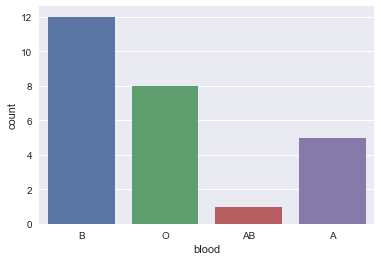

In [14]:
sns.set(style="darkgrid")
ax = sns.countplot(x="blood", data=BNK48Data)

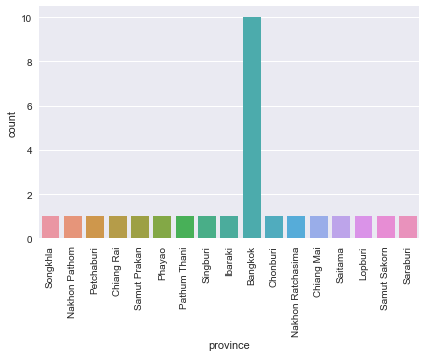

In [15]:
bx = sns.factorplot("province", data=BNK48Data, aspect=1.5, kind="count")
bx.set_xticklabels(rotation=90)

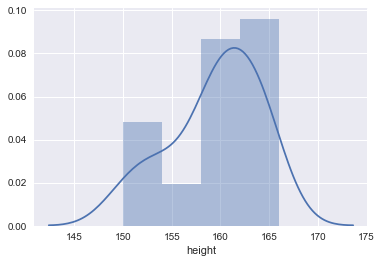

In [16]:
sns.distplot(BNK48Data["height"])

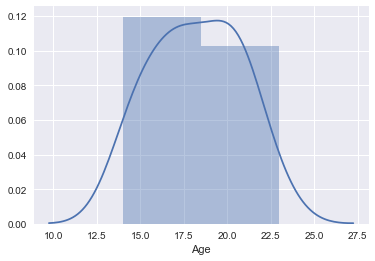

In [17]:
from math import floor
myday = pd.to_datetime('2018-03-5')
BNK48Data["Age"] = BNK48Data["birthdate"].apply(lambda x: floor(len(pd.date_range(start = x,end = myday, freq = "D"))/365))
sns.distplot(BNK48Data["Age"])